<a id='section01'></a>
# 1. Installing Dependencies and importing libraries


In [ ]:
!pip install tensorflow_text
!pip install -q tf-models-official==2.11.0
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.4 MB/s eta 0:00:00


In [44]:
!pip install pyyaml h5py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
path = 'https://drive.google.com/drive/folders/1x-su17q0fWYCgfimFBp1V6aYCxjRaY07?usp=share_link'

Mounted at /content/gdrive


In [45]:
from flask import Flask, request, jsonify, render_template
import os
import re
import shutil
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, STOPWORDS
from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

<a id='section02'></a>
# 2. Loading the data

## Train data

In [4]:
df_train = pd.read_csv(os.path.join(path,'/content/gdrive/MyDrive/Major Project/', 'train.csv'))

In [5]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df_train.shape

(159571, 8)

## Test data
- In the Toxic Comment Challenge dataset, the test set labels contain many -1 values because those samples were not included in the final evaluation of the competition. 

- Therefore, in order to properly evaluate the performance of a model on the test set, it is necessary to remove the samples with -1 labels and only use the samples with actual labels for evaluation


In [7]:
test_samples = pd.read_csv(os.path.join(path,'/content/gdrive/MyDrive/Major Project/', 'test.csv'))
test_labels = pd.read_csv(os.path.join(path,'/content/gdrive/MyDrive/Major Project/', 'test_labels.csv'))
df_test = pd.merge(test_samples, test_labels, on="id")

In [8]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [9]:
df_test.shape

(153164, 8)

In [10]:
# removing sample with labels equal to -1
df_test = df_test.loc[df_test['toxic'] >= 0]
df_test.reset_index(inplace=True)
df_test = df_test.drop(columns=['index'])

In [11]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [12]:
df_test.shape

(63978, 8)

<a id='section03'></a>
# 3. Exploratory Data Analysis
Exploratory Data Analysis (EDA) is a crucial step in any data analysis project, including text classification tasks like the Toxic Comment Challenge. By performing EDA on the dataset, we can gain important insights into the nature of the data and the distribution of the target classes. This can help in several ways:

- Understanding the distribution of the target classes: EDA can help identify the percentage of each class of toxic comment in the dataset. This can inform the data preprocessing and modeling decisions, such as how to handle class imbalance and which evaluation metrics to use.
- Identifying patterns in the data: EDA can help us identify patterns in the text data that can inform feature engineering and preprocessing steps. For example, we may identify common phrases or words that are strongly associated with a particular type of toxic comment.
- Selecting appropriate preprocessing techniques: EDA can inform the selection of preprocessing techniques that are appropriate for the specific dataset. For example, we may identify the need to remove stop words or perform stemming based on the characteristics of the text data.

Overall, performing EDA can help us make informed decisions throughout the text classification project and improve the accuracy and effectiveness of the models.

### NON-TOXIC comment example

In [13]:
df_train[df_train.columns[2:]].iloc[0]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 0, dtype: int64

In [14]:
#NON-TOXIC comment example
df_train.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

### TOXIC comment example

In [15]:
df_train[df_train.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

In [16]:
#TOXIC comment example
df_train.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

## WordCloud
A WordCloud is a data visualization technique that can be useful in gaining insights into the most frequently occurring words or phrases in a text dataset. In the context of the Toxic Comment Challenge, by analyzing the WordCloud, one can identify specific keywords or phrases that are strongly associated with toxic comments.

For instance, as we can see from the images below, a **toxic comment** is strongly associated with the words `suck` and `fuck`, while a **threat comment** is mostly related with the terms `die`, `will kill`, `going to kill`. 

Toxic comment:



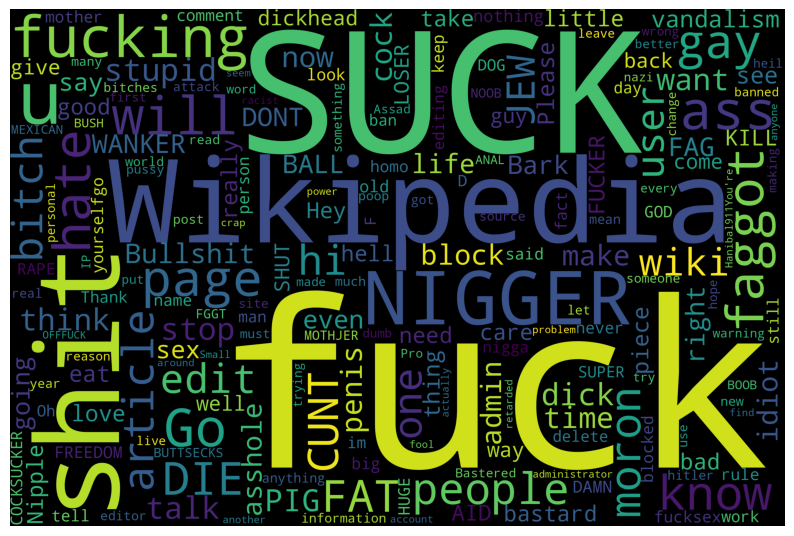


threat comment:



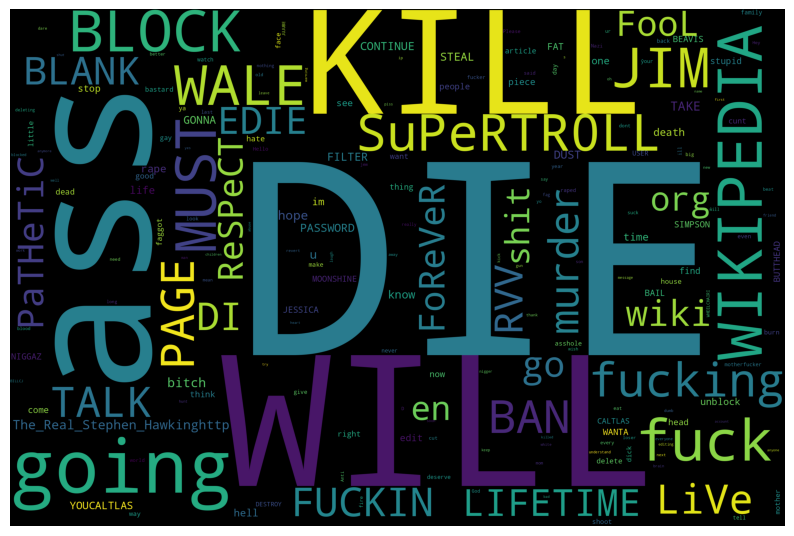

In [17]:
toxic_corpus = df_train.loc[df_train['toxic'] == 1]
toxic_corpus = toxic_corpus["comment_text"].tolist()

threat_corpus = df_train.loc[df_train['threat'] == 1]
threat_corpus = threat_corpus["comment_text"].tolist()


print("Toxic comment:")
print()
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(toxic_corpus))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1) 
plt.axis("off");
plt.show()

print()
print("threat comment:")
print()
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(threat_corpus))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1) 
plt.axis("off");
plt.show()


## Labels distribution
Now, let's take a look at the distribution of the labels in the Toxic Comment Challenge dataset:
-  The label distribution is an essential aspect of any classification problem as it determines the class imbalance and helps in understanding the problem's complexity. 
- A thorough analysis of the label distribution can help in developing appropriate strategies for data preprocessing, model selection, and evaluation. 
- In this case, an imbalanced distribution of the toxic comments can pose significant challenges in identifying and categorizing the different types of toxic comments accurately. 

Therefore, it is crucial to examine the label distribution in detail before proceeding with any further analysis.

## Labels distribution in train set 

In [18]:
for label in df_train.columns[2:]:
    print(df_train[label].value_counts(), '\n')

0    144277
1     15294
Name: toxic, dtype: int64 

0    157976
1      1595
Name: severe_toxic, dtype: int64 

0    151122
1      8449
Name: obscene, dtype: int64 

0    159093
1       478
Name: threat, dtype: int64 

0    151694
1      7877
Name: insult, dtype: int64 

0    158166
1      1405
Name: identity_hate, dtype: int64 



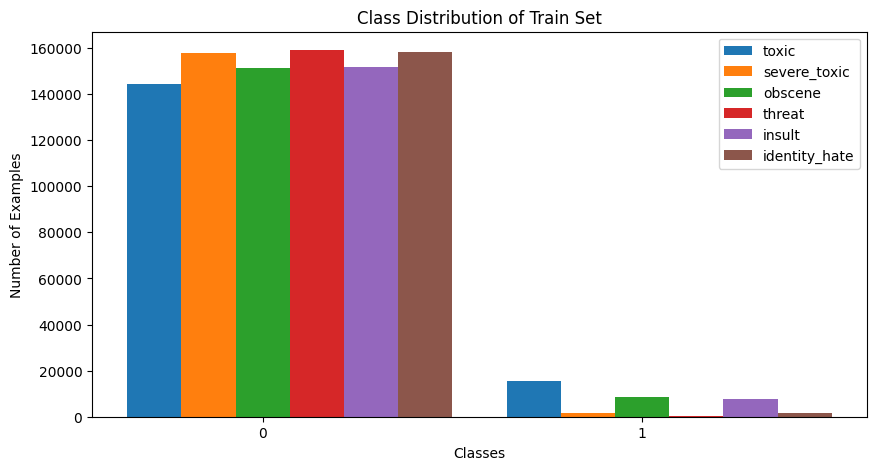

In [19]:
# Get the class distribution for each column
class_distributions = []
for i in range(2, 8):
    class_distributions.append(df_train.iloc[:, i].value_counts())

# Create a combined bar chart
labels = class_distributions[0].index
num_columns = len(class_distributions)
width = 1 / (num_columns + 1)

fig, ax = plt.subplots(figsize=(10, 5))

for i, class_dist in enumerate(class_distributions):
    x = np.arange(len(labels)) + (i + 1) * width
    bars = ax.bar(x, class_dist, width, label=df_train.columns[i+2])

ax.set_ylabel('Number of Examples')
ax.set_xlabel('Classes')
ax.set_title('Class Distribution of Train Set')
ax.set_xticks(x - width * (num_columns / 2))
ax.set_xticklabels(labels)
ax.legend()

plt.show()


## Comparing the labels distribution between train and test set

- In the context of the Toxic Comment Challenge dataset, which contains comments labeled with various degrees of toxicity, it is crucial to ensure that the same proportion of each label is present in both the train and test set. This is because if, for example, the train set has a higher proportion of toxic comments than the test set, then the model may become biased towards identifying comments as toxic, even if they are not.

- However, as expected, the organizers of the competition prepared the train and test sets to have a similar label distribution to ensure a fair and meaningful evaluation of the models submitted by participants.

In [20]:
labels = df_train.columns[2:]
# Compute the class distribution for the train set
train_class_distribution = df_train.iloc[:, 2:].sum()

# Compute the class distribution for the test set
test_class_distribution = df_test.iloc[:, 2:].sum()

print('Positive labels distribution in train set in percentage (%)')
print(round(train_class_distribution/df_train.shape[0]*100,2).sort_values(ascending = False))
print()
print(print('Positive labels distribution in test set in percentage (%)'))
print(round(test_class_distribution/df_test.shape[0]*100,2).sort_values(ascending = False))

Positive labels distribution in train set in percentage (%)
toxic            9.58
obscene          5.29
insult           4.94
severe_toxic     1.00
identity_hate    0.88
threat           0.30
dtype: float64

Positive labels distribution in test set in percentage (%)
None
toxic            9.52
obscene          5.77
insult           5.36
identity_hate    1.11
severe_toxic     0.57
threat           0.33
dtype: float64


## Distribution among only the positive labels

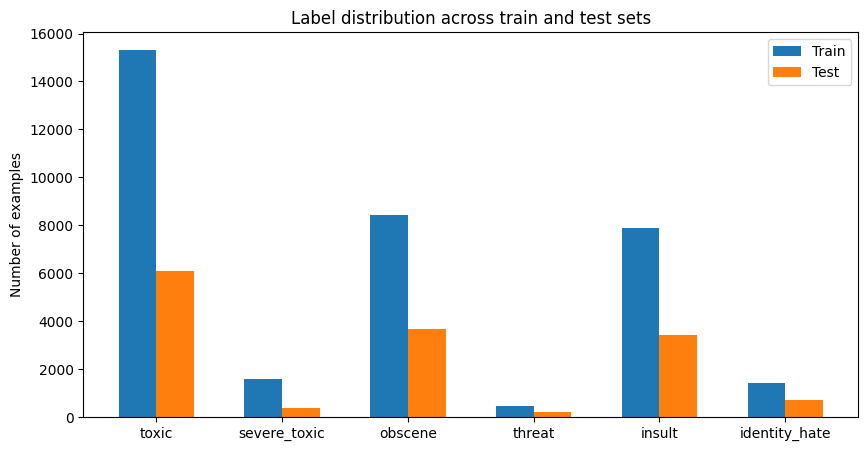

In [21]:
train_data = [train_class_distribution[label] for label in labels]
test_data = [test_class_distribution[label] for label in labels]

# plot the bar chart
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 5))
train_bars = ax.bar(x - width/2, train_data, width, label='Train')
test_bars = ax.bar(x + width/2, test_data, width, label='Test')

# add labels, title and legend
ax.set_ylabel('Number of examples')
ax.set_title('Label distribution across train and test sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# display the plot
plt.show()

In [22]:
train_class_distribution.sort_values(ascending = False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

In [23]:
print('Distribution among only positive labels in train set in percentage (%)')
print(round(train_class_distribution/train_class_distribution.sum()*100,2).sort_values(ascending = False))
print()
print('Distribution among only positive labels in test set in percentage (%)')
print(round(test_class_distribution/test_class_distribution.sum()*100,2).sort_values(ascending = False))

Distribution among only positive labels in train set in percentage (%)
toxic            43.58
obscene          24.07
insult           22.44
severe_toxic      4.54
identity_hate     4.00
threat            1.36
dtype: float64

Distribution among only positive labels in test set in percentage (%)
toxic            42.01
obscene          25.46
insult           23.64
identity_hate     4.91
severe_toxic      2.53
threat            1.46
dtype: float64


## Recap
The analysis of the distribution of the target labels has highilited the following aspects: 
- Firstly, it is true that the dataset is unbalanced, in the sense that the majority of the comments are labeled as non-toxic (i.e., negative class), while a relatively small proportion of comments are labeled as one or more of the toxic categories (i.e., positive class). This means that the dataset has a class imbalance problem, which can affect the performance of classification models, particularly for the minority class.

- Secondly, within the positive class, there is also some degree of imbalance among the different toxic categories. For example, some categories like `toxic` and `insult` have many more examples than others like `threat` and `identity hate`. This means that a model trained on this dataset may be biased towards the more frequent categories and may perform worse on the rarer categories.

<a id='section04'></a>
# 4. Text preprocessing
In the current Challenge, text preprocessing is especially important due to the nature of the task. Toxic comments can take many different forms and contain a variety of words and phrases that may not be immediately recognizable as toxic. Preprocessing can help to standardize the text data, remove noise and irrelevant information, and ensure that the models are trained on a consistent and clean dataset.



---
***NOTE*** 

*It is important to note that text preprocessing steps have been applied only to the RNN models in this task. This is because BERT model is based on a powerful attention mechanism that allows them to effectively handle noise and irrelevant information in the input text. As such, additional preprocessing steps may not provide much benefit when working with BERT model. Therefore, the text preprocessing steps outlined in this section should be considered only for Model I and Model II, which are based on RNN architectures.*

---

## 1st phase - Text normalization
First of all, I decided to normalize the text data since comments from online forums usually contain inconsistent language, use of special characters in place of letters (e.g. @rgument), as well as the use of numbers to represent letters (e.g. n0t). To tackle such inconsistencies in data, I decided to eploit `regex` library. The normalization phase can be divided into two steps: 

1. I created a dictionary (`RE_PATTERNS`) containing common representations of cuss words which are frequently found on online forums or social media platforms. 

2. I defined the function `clean_text`.

The function has three boolean arguments that determine which cleaning operations are applied:

- `remove_repeat_text`: If set to True, this will remove repeating characters in the text, such as "sooooo" becoming "so".
- `remove_patterns_text`: If set to True, this will replace any specific patterns of text with a specified target. The patterns and their corresponding targets are defined in a dictionary called RE_PATTERNS.
- `is_lower`: If set to True, this will convert all text to lowercase.

The cleaning operations that are always applied include:

- Replacing newline characters with spaces
- Removing any non-alphanumeric characters (except spaces)
- Removing any numbers
- Removing any extra spaces
- Removing any non-ASCII characters

These operations have been apllied both to train and test sets.

In [ ]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [ ]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  # Replacing newline characters with spaces
  text = str(text).replace("\n", " ")

  # Removing any non-alphanumeric characters (except spaces)
  text = re.sub(r'[^\w\s]',' ',text)

  # Removing any numbers
  text = re.sub('[0-9]',"",text)

  # Removing any extra spaces
  text = re.sub(" +", " ", text)

  # Removing any non-ASCII characters
  text = re.sub("([^\x00-\x7F])+"," ",text)
  
  return text 

In [ ]:
df2_train = df_train.copy()
df2_test = df_test.copy()
df2_train['comment_text']= df_train['comment_text'].apply(lambda x: clean_text(x))
df2_test['comment_text'] = df_test['comment_text'].apply(lambda x: clean_text(x))

In [ ]:
df_train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
df2_train.comment_text[0]

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now '

In [ ]:
df_test['comment_text'][3]

'" \n\n It says it right there that it IS a type. The ""Type"" of institution is needed in this case because there are three levels of SUNY schools: \n -University Centers and Doctoral Granting Institutions \n -State Colleges \n -Community Colleges. \n\n It is needed in this case to clarify that UB is a SUNY Center. It says it even in Binghamton University, University at Albany, State University of New York, and Stony Brook University. Stop trying to say it\'s not because I am totally right in this case."'

In [ ]:
df2_test['comment_text'][3]

' it says it right there that it is a type the type of institution is needed in this case because there are three levels of suny schools university centers and doctoral granting institutions state colleges community colleges it is needed in this case to clarify that ub is a suny center it says it even in binghamton university university at albany state university of new york and stony brook university stop trying to say it s not because i am totally right in this case '

## 2nd phase - stopwords removal and lemmatization
The second stage of the text preprocessing involves instead the removal of the stopwords and the lemmatization of each token in both train and test sets:
- Stop words are words that are commonly used but do not carry much meaning on their own, such as "the" and "and". Removing these words can help to simplify the text and improve model performance.
- lemmatization, insetad, is the process of reducing words to their base form (or lemma). For example, the word "running" could be reduced to its base form "run". Lemmatization can help to normalize the text and reduce the number of unique words that a model needs to learn.

To accomplish these two operations I exploited the `NLTK` library:


- The `stopwords` module from NLTK contains a list of common English stop words that can be removed from text during preprocessing. 
- The `WordNetLemmatizer` class from NLTK is used to perform lemmatization

The preprocess_text function tokenizes the input text using word_tokenize from NLTK. It then removes stop words using the stopwords module and lemmatizes the remaining tokens using WordNetLemmatizer. Finally, it joins the lemmatized tokens back into a string and returns the preprocessed text.



In [ ]:
df3_train = df2_train.copy()
df3_test = df2_test.copy()

In [ ]:
# Initialize NLTK objects
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a string
    preprocessed_text = " ".join(lemmatized_tokens)
    
    return preprocessed_text

# Apply the preprocessing function to the 'comment_text' column
df3_train['comment_text'] = df2_train['comment_text'].apply(preprocess_text)
df3_test['comment_text'] = df2_test['comment_text'].apply(preprocess_text)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df2_train['comment_text'][3]

' more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good_article_nominations transport '

In [ ]:
df3_train['comment_text'][3]

'make real suggestion improvement wondered section statistic later subsection type accident think reference may need tidying exact format ie date format etc later one else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn listed relevant form eg wikipedia good_article_nominations transport'

## 3th phase - Text vectorization
- This is an important preprocessing step when working with text data in machine learning because it allows the text data to be transformed into numerical data that can be used as input to machine learning models.

- One common technique for vectorizing text is through tokenization, which involves breaking the text into smaller units called tokens, such as words or phrases. Once tokenized, these units can then be mapped to numerical values to create vector representations of the text.

- In this context, the Keras `Tokenizer` class provides a useful tool for tokenizing and vectorizing text data. By using the `fit_on_texts()` method of the Tokenizer object, the internal vocabulary of the tokenizer can be updated based on the frequency of each word in the text data. 

- It is important to **fit the tokenizer only on the training set** because we want to learn the vocabulary and the word index based on the training data. If we fit the tokenizer also on the test set, we would be introducing bias into our model. The model would have knowledge of the test set and could potentially overfit to it, resulting in poorer performance on unseen data.

- After fitting the tokenizer on the training data, we can use `texts_to_sequences()` method to convert the texts, in both the training and test data, to sequences of integers representing the token indices of the words in the original text. This ensures that the same vocabulary is used for both the training and test data, which is important for the model to generalize well to new data.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df3_train['comment_text'].values)

In [ ]:
word_index = tokenizer.word_index
NUM_FEATURES = len(word_index)
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  158504


In [ ]:
word_index

{'article': 1,
 'page': 2,
 'wikipedia': 3,
 'talk': 4,
 'one': 5,
 'please': 6,
 'would': 7,
 'like': 8,
 'see': 9,
 'source': 10,
 'think': 11,
 'also': 12,
 'know': 13,
 'time': 14,
 'people': 15,
 'user': 16,
 'edit': 17,
 'use': 18,
 'make': 19,
 'may': 20,
 'image': 21,
 'get': 22,
 'say': 23,
 'thanks': 24,
 'need': 25,
 'name': 26,
 'link': 27,
 'even': 28,
 'good': 29,
 'want': 30,
 'well': 31,
 'information': 32,
 'way': 33,
 'could': 34,
 'u': 35,
 'comment': 36,
 'deletion': 37,
 'go': 38,
 'editor': 39,
 'section': 40,
 'question': 41,
 'help': 42,
 'thing': 43,
 'first': 44,
 'wp': 45,
 'fact': 46,
 'new': 47,
 'look': 48,
 'work': 49,
 'point': 50,
 'editing': 51,
 'fuck': 52,
 'discussion': 53,
 'right': 54,
 'edits': 55,
 'thank': 56,
 'made': 57,
 'many': 58,
 'much': 59,
 'used': 60,
 'really': 61,
 'find': 62,
 'take': 63,
 'reference': 64,
 'deleted': 65,
 'read': 66,
 'add': 67,
 'list': 68,
 'since': 69,
 'change': 70,
 'someone': 71,
 'reason': 72,
 'wiki': 73,


In [ ]:
list_tokenized_train = tokenizer.texts_to_sequences(df3_train['comment_text'].values)
list_tokenized_test = tokenizer.texts_to_sequences(df3_test['comment_text'].values)

In [ ]:
print(list_tokenized_train[:3])

[[468, 55, 57, 541, 3878, 9873, 620, 230, 115, 5500, 2208, 2554, 47, 1006, 10034, 2417, 6, 144, 180, 4, 2, 69, 2937], [13745, 967, 423, 2568, 3925, 2356, 24, 4, 812, 100], [292, 298, 61, 153, 17, 164, 239, 1986, 377, 386, 32, 477, 55, 253, 4, 2, 122, 279, 2080, 600, 342]]


In [ ]:
print(list_tokenized_test[:3])

[[56, 891, 11, 906, 7, 248, 96, 53], [872, 370, 130, 2887], [1033, 13282, 175, 67, 714, 61, 86, 33, 15, 13282, 1117, 203, 714, 4934, 15538, 892, 1190, 2426, 154, 881, 440, 185, 5871, 1343, 83, 181, 1234, 2934, 1704, 3565, 9074, 557, 12847, 7645, 1, 685, 640, 247]]


## 4th phase - Padding 
- Padding involves adding zeros or other placeholder values to the end of shorter sequences to make all sequences in a dataset of equal length, either by padding them to the length of the longest sequence in the dataset or to a fixed length specified by hand. This is important because deep learning model such as Recurrent Neural Networks (RNNs) or Transformers (e.g. BERT) require inputs of a fixed size.
Padding ensures that all sequences have the same length, allowing these models to process them in a consistent manner. 

- While Tensorflow Hub provides a convenient `preprocess()` function for preparing text data for BERT models, when working with RNNs, we typically need to use the `pad_sequences()` function from Keras to pad the sequences to a fixed length.

- However, the fixed length can be considerd as a hyperparamter and we need to choose carefully this value. In order to make an informed decision, I decided to plot the distribution of comments within the dataset.

- Upon inspection, it became apparent that 98% of the comments had a length of less than 203 words. Consequently, I chose to set the fixed length of the input sequences to 200.

- It is important to note that any input sequences longer than 200 words will be truncated to this length.

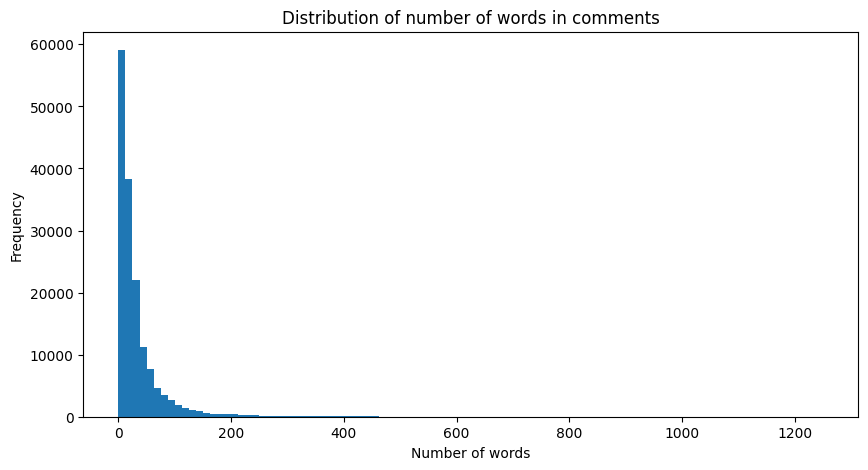

In [ ]:
import matplotlib.pyplot as plt

# Count the number of words in each comment
lengths = df3_train['comment_text'].str.split().apply(len)

# Plot the distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(lengths, bins=100)
ax.set_xlabel('Number of words')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of number of words in comments')
plt.show()


In [ ]:
lengths = df3_train['comment_text'].str.split().apply(len)
percentile_98 = np.percentile(lengths, 98)
percentile_98

203.0

In [ ]:
MAX_LENGTH = 200

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LENGTH, padding = 'post')
X_test  = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LENGTH, padding = 'post')

In [ ]:
X_train

array([[  468,    55,    57, ...,     0,     0,     0],
       [13745,   967,   423, ...,     0,     0,     0],
       [  292,   298,    61, ...,     0,     0,     0],
       ...,
       [26741,  6327,  4454, ...,     0,     0,     0],
       [   48,     8,   125, ...,     0,     0,     0],
       [   61,    11,   159, ...,     0,     0,     0]], dtype=int32)

In [ ]:
print("Shape train set:", X_train.shape)

Shape train set: (159571, 200)


In [ ]:
X_test

array([[   56,   891,    11, ...,     0,     0,     0],
       [  872,   370,   130, ...,     0,     0,     0],
       [ 1033, 13282,   175, ...,     0,     0,     0],
       ...,
       [ 1958,    30,   715, ...,     0,     0,     0],
       [ 5287,  5511,   710, ...,     0,     0,     0],
       [14251, 24372,  2988, ...,     0,     0,     0]], dtype=int32)

In [ ]:
print("Shape test set:", X_test.shape)

Shape test set: (63978, 200)


In [ ]:
y_train = df_train[df_train.columns[2:]].values
y_test = df_test[df_test.columns[2:]].values

In [ ]:
y_train

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
y_train.shape

(159571, 6)

In [ ]:
y_test

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
y_test.shape

(63978, 6)

## The preprocessing model
Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT

As we can see, now we have the 3 outputs from the preprocessing that a BERT model would use:

1. `input_word_ids`: this array contains integer indices that represent the words in the input sentence. Each sentence is tokenized into a sequence of word pieces, and these indices refer to the vocabulary indices of those word pieces.
2. `input_mask`: this array specifies which word pieces in the `input_word_ids` array should be attended to by the model and which ones should be ignored. In particular, the input mask contains 1's for all the word pieces that should be attended to by the model and 0's for all the word pieces that should be ignored.
3. `input_type_ids`: this array specifies which tokens belong to the first sentence and which tokens belong to the second sentence (if there is a second sentence). For a single sentence classification task like ours, all the values in this array will be 0.

Another important point:

The input is **truncated to 128 tokens**. The number of tokens can be customized, but because of limited GPU resources at disposal it was not possible to consider 200 tokens as the previous models.


## Using the BERT model
Before putting BERT into your own model, let's take a look at its outputs. We will load it from TF Hub and see the returned values.
The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs.

However, for our fine-tuning task, we are interested only on the `pooled output` which is a fixed-size representation of the entire input sequence that summarizes the most important information in the text. 



In [24]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [25]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [26]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [27]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [28]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.92165023 -0.39354268 -0.5395946   0.6824618   0.43867552 -0.14013615
  0.877425    0.26047567 -0.63134795 -0.9999657  -0.26342827  0.85107595]


## Defining the model
Now we will create the fine-tuned model. In this case, we will create a BERT model for multilabel text classification by adding a dropout layer and a dense layer. We use a dropout layer to prevent overfitting and a dense layer to perform the final classification.

Here is an explanation of each line of the code below:

1. `text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')`: This line defines an input layer that will take string input with a variable length.

2. `preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')`: This line creates a Keras layer using the BERT preprocessor module provided by TensorFlow Hub.

3. `encoder_inputs = preprocessing_layer(text_input)`: This line applies the preprocessor layer to the input text.

4. `encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')`: This line creates a Keras layer using the BERT encoder module provided by TensorFlow Hub. This layer is trainable, meaning its weights can be updated during training.

5. `outputs = encoder(encoder_inputs)`: This line applies the encoder layer to the preprocessed input to get the BERT outputs.

6. `net = outputs['pooled_output']`: This line extracts the pooled output from the BERT outputs. This output is a fixed-size representation of the input text that summarizes the most important information in the text.

7. `net = tf.keras.layers.Dropout(0.5)(net)`: This line adds a dropout layer with a rate of 0.5 to help prevent overfitting.

8. `net = tf.keras.layers.Dense(6, activation='sigmoid', name='classifier')(net)`: This line adds a dense layer with a sigmoid activation function and 6 units, which represents the output classes of the classifier.

9. `return tf.keras.Model(text_input, net)`: This line returns the Keras model that takes input from the `text_input` layer and outputs the classification results from the `net` layer.


In [29]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.5)(net)
  net = tf.keras.layers.Dense(6, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [30]:
tf.keras.backend.clear_session()
classifier_model = build_classifier_model()

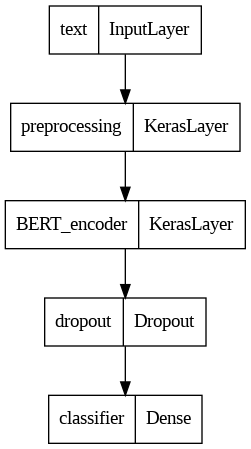

In [31]:
tf.keras.utils.plot_model(classifier_model)

## Building data pipeline
As with the previous model, it is crucial to prepare an input pipeline for our data to ensure faster training of the model. However, in contrast to the previous models, the text is not preprocessed in this case as it will be handled by the preprocessing function of Tensorflow Hub.

In [32]:
y = df_train[df_train.columns[2:]]
ds= tf.data.Dataset.from_tensor_slices((df_train['comment_text'], y))
ds = ds.cache()
ds = ds.shuffle(160000)
ds = ds.batch(32)
ds = ds.prefetch(16) 

In [33]:
train_ds = ds.take(int(len(ds)*.8))
val_ds = ds.skip(int(len(ds)*.8)).take(int(len(ds)*.2))

In [34]:
y_test = df_test[df_test.columns[2:]]
test= tf.data.Dataset.from_tensor_slices((df_test['comment_text'], y_test))
test = test.cache()
test = test.batch(32)
test = test.prefetch(16) 

## Optimizer
- To fine-tune our BERT model, we will use the same optimizer that BERT was originally trained with: the Adaptive Moments optimizer (Adam). This optimizer minimizes the prediction loss and performs regularization by weight decay, which is also referred to as `AdamW`.

- To determine the learning rate (init_lr), we will follow the same schedule as BERT pre-training. This involves a linear decay of a notional initial learning rate, preceded by a linear warm-up phase over the first 10% of training steps (num_warmup_steps). As recommended in the BERT paper, the initial learning rate for fine-tuning is smaller than the pre-training learning rate and should be chosen from a set of values such as 5e-5, 3e-5, or 2e-5, based on performance on a validation set (3e-5 in this case).

In [35]:
epochs = 1
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [36]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])

## Training the model

In [37]:
print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(x=train_ds,
                               
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
3989/3989 [==============================] - 649s 158ms/step - loss: 0.0578 - f1_score: 0.4676 - val_loss: 0.0339 - val_f1_score: 0.7044


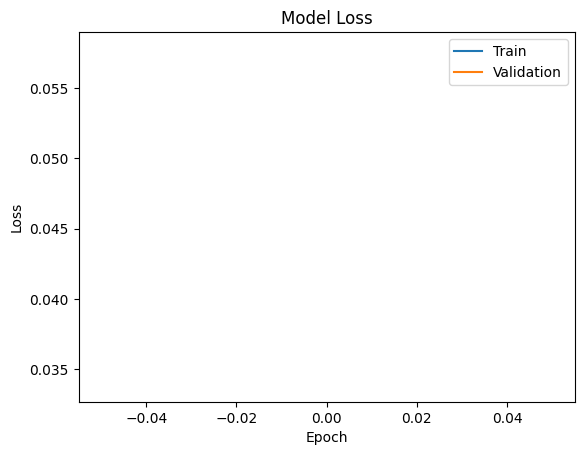

In [38]:
# Plot the loss and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

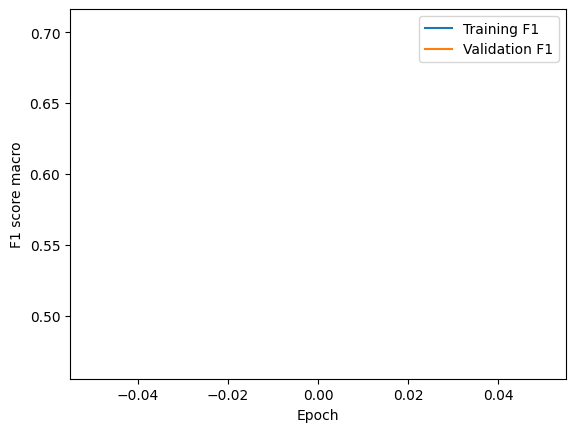

In [39]:
# Plot the F1 macro score on the training and validation sets
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 score macro')
plt.legend()
plt.show()

## Evaluating the model

In [41]:
from sklearn.metrics import classification_report
# Predict the labels for all batches in your test dataset
y_pred = []
y_true = []
label_names = df_train.columns[2:]

for X_batch, y_batch in test:
    y_pred_batch = classifier_model.predict(X_batch)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_batch)

# Convert the predicted and true labels into numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

1/1 [==============================] - 1s 908ms/step


In [42]:
threshold = 0.5
y_pred_thresh = (y_pred >= threshold).astype(int)

# Compute the classification report
report = classification_report(y_true, y_pred_thresh, target_names=label_names, zero_division = 1)
print(report)

               precision    recall  f1-score   support

        toxic       0.53      0.92      0.67      6090
 severe_toxic       0.39      0.51      0.44       367
      obscene       0.61      0.82      0.70      3691
       threat       0.49      0.48      0.49       211
       insult       0.63      0.79      0.70      3427
identity_hate       0.69      0.59      0.63       712

    micro avg       0.57      0.83      0.67     14498
    macro avg       0.56      0.68      0.61     14498
 weighted avg       0.58      0.83      0.67     14498
  samples avg       0.91      0.98      0.90     14498



The results of our text classification task demonstrate that using BERT allowed us to increase our performance considerably. Specifically, the F1 score improved from 0.55 and 0.56 with our previous models to 0.62 with the BERT model.

This improvement can be attributed to several factors: 
- The improvement in performance from our previous models to the BERT model can be attributed, in part, to the fact that transformers are a more powerful model architecture than RNNs. Unlike RNNs, transformers are not limited by the vanishing gradient problem, which can make it difficult for RNNs to learn dependencies over long sequences. Additionally, transformers are able to capture contextual information from across the entire input sequence, whereas RNNs process the sequence one element at a time in a fixed order.
- Moreover, BERT's fine-tuning capability allows for optimization of the model for specific downstream tasks, such as our text classification task. This can further improve performance. 

Overall, the results demonstrate the power of BERT for improving text classification performance.

<a id='section09'></a>
# 9. Comparison of models performance

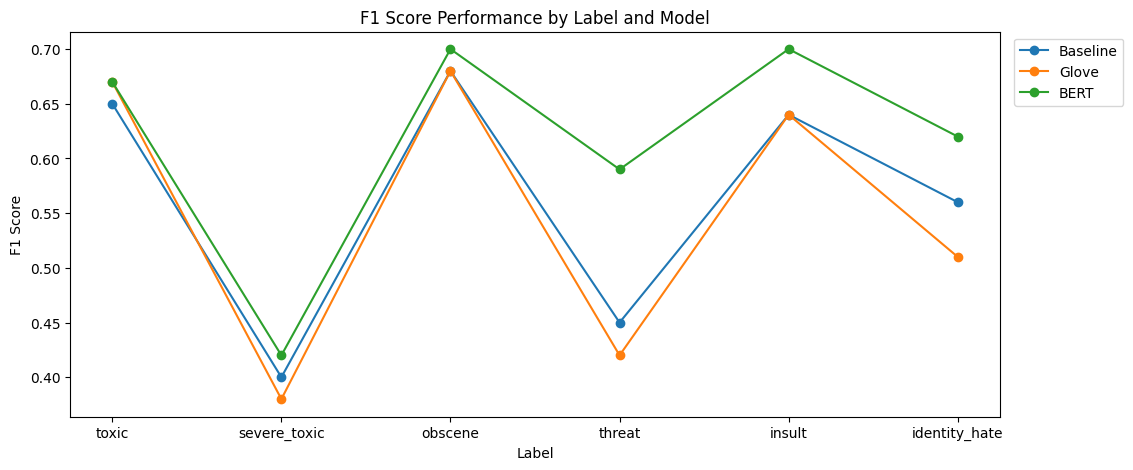

In [43]:
import matplotlib.pyplot as plt

# define the labels and f1 scores for each model
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
f1_scores_model1 = [0.65, 0.40, 0.68, 0.45, 0.64, 0.56]
f1_scores_model2 = [0.67, 0.38, 0.68, 0.42, 0.64, 0.51]
f1_scores_model3 = [0.67, 0.42, 0.70, 0.59, 0.70, 0.62]

# create a list of x values for each label
x_values = list(range(len(labels)))

plt.figure(figsize=(12,5))
# plot the f1 scores for each model
plt.plot(x_values, f1_scores_model1, 'o-', label='Baseline')
plt.plot(x_values, f1_scores_model2, 'o-', label='Glove')
plt.plot(x_values, f1_scores_model3, 'o-', label='BERT')

# set the x-axis labels to the label names
plt.xticks(x_values, labels)

# add a legend
plt.legend()

# set the title and axis labels
plt.title('F1 Score Performance by Label and Model')
plt.xlabel('Label')
plt.ylabel('F1 Score')
plt.legend(bbox_to_anchor=(1.14, 1), loc='upper right')
# display the plot
plt.show()

    
PATH = '/content/gdrive/MyDrive/Major Project/HSD.pth'
